# Propeller identification
We want to charchterize the transfer function of a drone propeller (BLDC motor) by measuring a set of datapoints and applying machine learning techniques to approximate the parameters

## Collection of the data points
We collect data by interfacing the computer and the board via a serial port.
In the PC side we use the pySerial library

In [1]:
import serial   # pip install pyserial, not pip install serial !

# Serial port parameters
port = '/dev/ttyUSB0'   # Depends on the OS
baud = 9600
timeout = 3

# Open te serial port
ser = serial.Serial(port, baud, timeout=timeout)
ser.flush()

We now define two function to simplify reading and writing data via the serial port.
Note that this is specific to this particular setup.

In [2]:
# Returns a string, already decoded and polished
def my_readline():
    line = ser.readline().decode('UTF-8').strip()
    return line

# Writes a message, following the protocol we defined:
# <message>
def my_write(message):
    ser.write(("<"+message+">").encode())

To get the data, we first must send a message to the board to tell how to measure. We have to send:
- the command: what we want to do
- the step: the distance between each input value. Can be negative
- the max pwm value to test
- the number of samples per input value

After that, the board will start the test and will send back data, line by line.
Each line sent by the board is a sample, already formatted to be written in a .csv file.
While we read the data, we also write it into a .csv file to store all the samples.

In [3]:
import csv

# Given the parameters, build the message string
def build_message(command, n_samples, step, max_pwm):
    # The words are separated by a space
    message = " ".join([command, str(n_samples), str(step), str(max_pwm)])
    return message

def build_message(list_of_string):
    message = " ".join(list_of_string)
    return message

# Given a message and a filename, send the message and store the data in the specified file
def get_dataset(message, filename):
    ser.flush()
    # Open the file
    file = open(filename, 'a')
    file.truncate(0)

    # Setup the csv
    csv_writer = csv.writer(file)

    # Send the command to get the measurements
    my_write(message)

    # Listen to the response
    while 1:
        # Read a line = a row of the matrix S = a sample
        line = my_readline()

        # Check if the line is empty => skip
        if line == '':
            continue

        # If there is something, I check if it is the termination message
        if line == "Finished":
            file.close()
            print("Finished")
            break

        # Forced stop
        if line == 'STOP':
            file.close()
            print("Stopped")
            break

        # Exception unhandled
        if line == 'Arduino is ready':
            print("Exception occured")
            break

        # If I'm here it is a proper sample
        print(line)
        values = line.split(',')
        if 'Message' in values[0]:
            continue
        
        csv_writer.writerow(values)

Finally we can collect the data

In [5]:
# Collect the data for the ramp
command = 'R'   # Measure
n_samples = 10  # How many samples do I want to average for each input value
step = 5      # Step for the input signal
min_pwm = 1180   # Start from here
max_pwm = 1400 # Max value to test
filename = "Dataset_ramp.csv"

In [ ]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command, str(n_samples), str(step), str(min_pwm), str(max_pwm)]), filename)

## Plot
After collecting the data, we draw a beautiful plot.

Before actually drawing the plot, we have to get the data from the file we created

In [4]:
import pandas
data_frame = pandas.read_csv(filename)
print(data_frame.tail())

NameError: name 'filename' is not defined

In [5]:
# https://matplotlib.org/stable/tutorials/introductory/quick_start.html#sphx-glr-tutorials-introductory-quick-start-py
import matplotlib as mpl
import matplotlib.pyplot as plt

data_frame.plot(x='PWM', y='RPM', kind='scatter', s=3, c='blue')
data_frame.plot(x='PWM', y='Thrust', kind='scatter', s=3, c='red')
data_frame.plot(x='RPM', y='Thrust', kind='scatter', s=3, c='red')

NameError: name 'data_frame' is not defined

## Step response
Now we measure the step response of the propeller.

The value at which we measure it coincides with the chosen operating point in the final system.

Additionally, we indicate to the board which interval to measure.

In [6]:
command = 'S'
step_value = 1500
n_samples = 1000
max_time = 2000    # milliseconds
filename = 'Dataset_step.csv'

In [14]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command, str(step_value), str(max_time)]), filename)

Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0
T,RPM
0,0
222, 134.558
261, 780.660
289, 1076.735
313, 1235.178
336, 1314.118
359, 1322.168
380, 1368.363
402, 1370.364
424, 1413.161
445, 1409.973
466, 1449.766
486, 1443.001
507, 1480.531
527, 1470.372
547, 1505.722
567, 1492.983
587, 1526.795
607, 1512.554
626, 1545.515
646, 1529.676
665, 1562.175
684, 1545.515
703, 1576.707
722, 1558.684
741, 1589.236
760, 1569.202
779, 1599.403
798, 1578.781
817, 1608.234
836, 1586.630
854, 1616.118
873, 1594.134
892, 1621.797
910, 1599.488
929, 1627.957
948, 1605.136
966, 1633.009
985, 1609.787
1003, 1638.002
1021, 1614.292
1040, 1641.767
1058, 1617.774
1076, 1644.827
1095, 1620.570
1113, 1647.899
1132, 1623.289
1150, 1650.801
1168, 1625.135
1186, 1651.891
1205, 1626.722
1223, 1654.077
1241, 1628.488
1260, 1655.264
1278, 1630.789
1296, 1657.092
1314, 1632.031
1333, 1658.925
1351, 1633.809
1369, 1660.762
1387, 1633.987
1405, 1660.578
1424, 1635.680
1442, 1662.418
1460, 1637.

        T       RPM
442  3975  5536.077
443  3980  5462.491
444  3986  5536.077
445  3991  5465.477
446  3996  5537.099


<Axes: xlabel='T'>

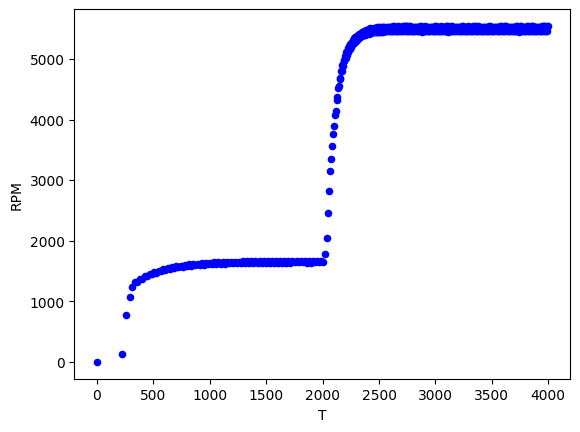

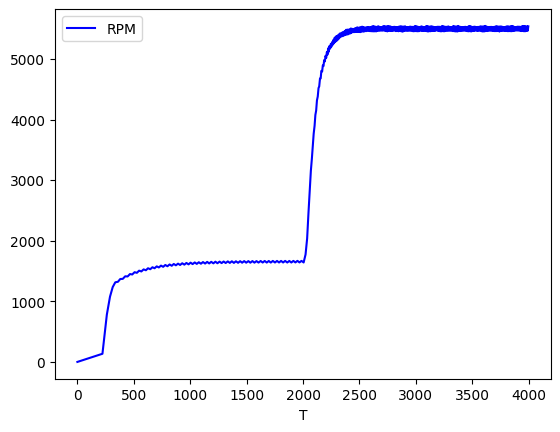

In [15]:
data_frame_step = pandas.read_csv(filename)
print(data_frame_step.tail())
data_frame_step.plot(x='T', y='RPM', kind='scatter', c='blue')
data_frame_step.plot(x='T', y='RPM', kind='line', c='blue')

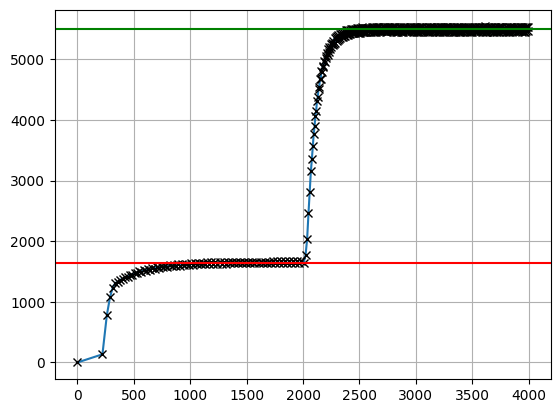

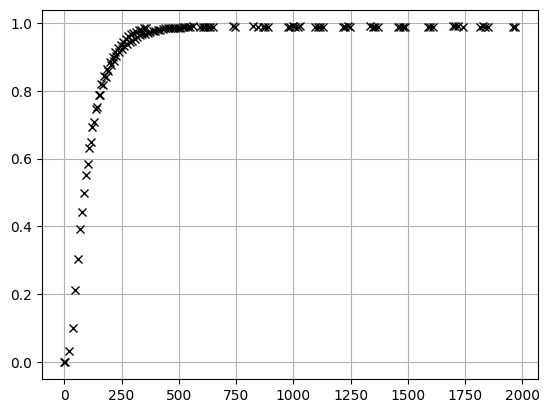

In [16]:
fig, ax = plt.subplots()
ax.grid(True)
ax.plot(data_frame_step['T'], data_frame_step['RPM'])
ax.plot(data_frame_step['T'], data_frame_step['RPM'], 'kx')

baseline = data_frame_step[ (data_frame_step['T'] > 1000) & (data_frame_step['T'] < 2000) ]
baseline_rpm = baseline['RPM'].mean()
ax.axhline(baseline_rpm, color='r')

step_df = data_frame_step[ data_frame_step['T'] > 2000 ]
step_ss_df = data_frame_step[ (data_frame_step['T'] > 3000) & (data_frame_step['T'] < 4000) ]
ss_rpm = step_ss_df['RPM'].mean()
ax.axhline(ss_rpm, color='g')

step_normalized = step_df.copy()
step_normalized['T'] = step_normalized['T'] - 2000
step_normalized['RPM'] = (step_normalized['RPM'] - baseline_rpm) / (ss_rpm - baseline_rpm)
step_normalized = step_normalized[ step_normalized['RPM'] < 0.99]
new_row = pandas.DataFrame({'T':0, 'RPM':0}, index=[0])
step_normalized = pandas.concat([new_row, step_normalized[:]]).reset_index(drop = True)

fig, ax = plt.subplots()
ax.plot(step_normalized['T'], step_normalized['RPM'], 'kx');
ax.grid(True)

### Non linear regression

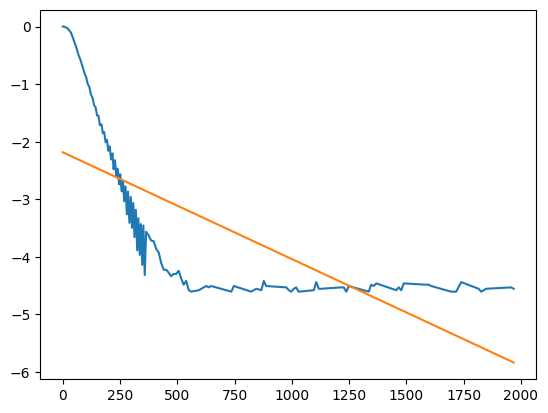

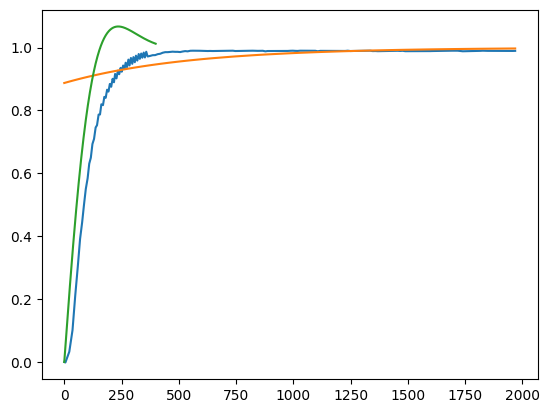

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Compute the natural logarithm of the rpm
step_normalized['RPM_P'] = step_normalized.apply( lambda row : np.log( 1 - row.RPM ), axis = 1 )

fig, ax = plt.subplots()
ax.plot(step_normalized['T'], step_normalized['RPM_P'])

X = step_normalized['T'].to_numpy().reshape(-1,1)
Y = step_normalized['RPM_P'].to_numpy()

reg = LinearRegression().fit(X,Y)
prediction = reg.predict(X)

ax.plot(X, prediction)

fig, ax = plt.subplots()
ax.plot(step_normalized['T'], step_normalized['RPM'])
ax.plot(X, 1 - np.exp(prediction))

tau1 = -0.01
wn = 0.01

t = np.arange(0, 400, 1)
ax.plot(t, 1 - np.multiply( np.exp(tau1*t), np.cos(wn*t) ))

In [7]:
command = 'S'
step_value = 1500
max_time = 2000    # milliseconds
N = 5

for i in range(1,1+N):
    filename = "Dataset_step_" + str(i) + ".csv"
    get_dataset(build_message([command, str(step_value), str(max_time)]), filename)

Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0
T,RPM
0,0
Finished
Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0
T,RPM
0,0
Finished
Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0


KeyboardInterrupt: 

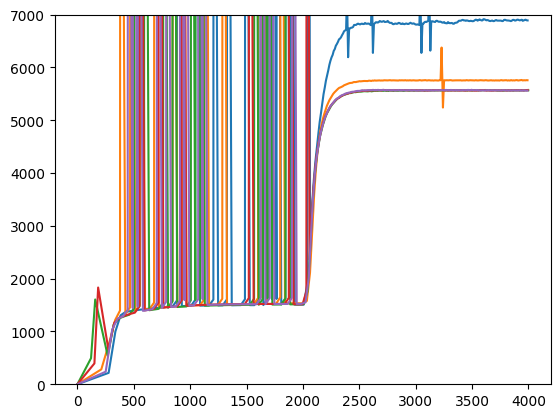

In [21]:
fig, ax = plt.subplots()

for i in range(1,1+N):
    filename = "Dataset_step_" + str(i) + ".csv"
    data_frame_step = pandas.read_csv(filename)

    ax.plot(data_frame_step['T'], data_frame_step['RPM'])
    ax.set_ylim(0, 7000)
